### Importing necessary libraries

In [1]:
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\su1qt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\su1qt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Import other necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from transformers import pipeline
import sklearn
import vaderSentiment


In [3]:
import os
# Define the paths
scripts_raw_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\scripts_raw'  # Adjusted path
dialogues_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues'      # Output directory
output_viz_path = r'C:\Users\su1qt\Significant Projects\Honors Research\outputs\Mulan'

# Ensure the output directory exists
if not os.path.exists(dialogues_path):
    os.makedirs(dialogues_path)

# Define the path to the Mulan script
script_filename = 'mulan_script.txt'
script_path = os.path.join(scripts_raw_path, script_filename)

# Verify that the script file exists
if not os.path.isfile(script_path):
    print(f"Error: The file {script_path} does not exist.")
else:
    print(f"Processing script: {script_path}")

Processing script: C:\Users\su1qt\Significant Projects\Honors Research\data\scripts_raw\mulan_script.txt


In [4]:
import re
character_pattern = re.compile(r'^[A-Z][A-Z\s\-#\d]*:$')
dialogue_pattern = re.compile(r'^([A-Za-z][A-Za-z\s\-\d#]*)(?:\s*\[.*?\])?:\s*(.*)')
scene_pattern = re.compile(r'^\[.*\]$')

## Dialogue Extraction Function

In [5]:
def extract_dialogues(script_path):
    dialogues = []
    with open(script_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    current_dialogue = None
    
    for line_number, line in enumerate(lines, start=1):
        line = line.strip()
        
        # Skip empty lines
        if not line:
            continue
        
        # Skip scene descriptions that are in square brackets and do not have dialogue
        if line.startswith('[') and line.endswith(']'):
            continue
        
        # Try to match dialogue lines
        match = re.match(r'^([A-Za-z][A-Za-z\s\-\d#]*)(?:\s*\[.*?\])?:\s*(.*)', line)
        if match:
            character = match.group(1)
            dialogue = match.group(2)
            
            # Remove any stage directions within the dialogue
            dialogue = re.sub(r'\[.*?\]|\(.*?\)', '', dialogue).strip()
            
            if dialogue:
                dialogues.append({
                    'Character': character,
                    'Dialogue': dialogue
                })
                current_dialogue = None
            else:
                current_dialogue = {
                    'Character': character,
                    'Dialogue': ''
                }
        else:
            # If current_dialogue is not None, append this line to it
            if current_dialogue is not None:
                # Remove any stage directions within the line
                dialogue_line = re.sub(r'\[.*?\]|\(.*?\)', '', line).strip()
                if dialogue_line:
                    current_dialogue['Dialogue'] += ' ' + dialogue_line
            else:
                # Maybe it's a continuation of the previous dialogue
                if dialogues:
                    last_dialogue = dialogues[-1]
                    dialogue_line = re.sub(r'\[.*?\]|\(.*?\)', '', line).strip()
                    if dialogue_line:
                        last_dialogue['Dialogue'] += ' ' + dialogue_line
    
    # Debug: Print the number of dialogues extracted
    print(f"Extracted {len(dialogues)} dialogues from the script.")
    
    return dialogues

## Creating Dataframe

In [6]:
# Extract dialogues from the script
if os.path.isfile(script_path):
    mulan_dialogues = extract_dialogues(script_path)
    
    # Debug: Print the number of dialogues extracted
    print(f"Number of dialogues extracted: {len(mulan_dialogues)}")
    
    # Debug: Print the first few dialogues
    print("First few dialogues extracted:")
    for dialogue in mulan_dialogues[:5]:
        print(dialogue)
    
    # Add film title to each dialogue entry
    for dialogue in mulan_dialogues:
        dialogue['Film Title'] = 'Mulan'
    
    # Create a DataFrame
    df_mulan_dialogues = pd.DataFrame(mulan_dialogues)
    
    # Debug: Print DataFrame columns
    print("DataFrame columns:", df_mulan_dialogues.columns.tolist())
    
    # Rearrange columns if they exist
    expected_columns = ['Film Title', 'Character', 'Dialogue']
    existing_columns = df_mulan_dialogues.columns.tolist()
    columns_to_select = [col for col in expected_columns if col in existing_columns]
    
    if columns_to_select:
        df_mulan_dialogues = df_mulan_dialogues[columns_to_select]
    else:
        print("Expected columns are not in the DataFrame.")
        print("Available columns:", existing_columns)
    
    # Remove empty dialogues
    df_mulan_dialogues = df_mulan_dialogues[df_mulan_dialogues['Dialogue'] != '']
    
    # Reset index
    df_mulan_dialogues.reset_index(drop=True, inplace=True)
    
    # Save to CSV
    output_file = os.path.join(dialogues_path, 'mulan_dialogues.csv')
    df_mulan_dialogues.to_csv(output_file, index=False)
    
    print(f"Extracted dialogues saved to {output_file}")
else:
    print(f"Cannot find the script file at {script_path}. Please check the file path.")

Extracted 482 dialogues from the script.
Number of dialogues extracted: 482
First few dialogues extracted:
{'Character': 'Guard ', 'Dialogue': "We're under attack!  Light the signal! [Guard runs to the tower and up the ladder as Hun Bald Man #1 and Hun Long Hair Man appear trying to stop him.  Hun Bald Man #1 breaks the ladder with his sword just as Guard reaches the top.  The guard picks up the torch to light the fire and sees Shan-Yu jump over the edge of the tower and looks at him across from the caldron.  The guard throws the torch into the caldron lighting a large fire.  Shan-Yu watches as each tower lights their caldrons one by one]"}
{'Character': 'Guard ', 'Dialogue': "Now all of China knows you're here."}
{'Character': 'Shan-Yu ', 'Dialogue': 'Perfect. [Cut to the palace.  The large doors to the central chamber open as General Li walks in flanked on his left and right by soldiers and approaches the Emperor. He bows, then looks up]'}
{'Character': 'General Li', 'Dialogue': 'You

## Annotate Scripts with Character Metadata

In [7]:
# Load the dialogues DataFrame
dialogues_df = pd.read_csv('C:/Users/su1qt/Significant Projects/Honors Research/data/dialogues/mulan_dialogues.csv')

# Get a list of unique characters
unique_characters = dialogues_df['Character'].unique()

print("List of unique characters:")
for character in unique_characters:
    print(character)

List of unique characters:
Guard 
Shan-Yu 
General Li
Chi Fu
Emperor 
Emperor
Mulan
Fa Zhou
Mulan 
Fa Zhou 
Bath Lady 
Fa Li
Grandma Fa 
Fa Li 
Grandma Fa
Bath Lady
Fa Li and others
Chorus
Maidens and Mulan
Maiden #1
Maiden #2
Maiden #3
Maiden #4
Mulan and Maidens
Matchmaker 
Matchmaker
Townspeople 
Chi Fu 
First Ancestor 
Mushu 
Mushu
First Ancestor
Ancestor 1
Ancestor 3
Ancestor 2
Ancestor 4 
Ancestor 5
Ancestor 6
Ancestor 7
Ancestor 8 
Fa Deng 
Cri-Kee
Cri-Kee 
Hun Long-Hair Guy
Scout #1
Scout #2
Archer Guy 
Tattoo Soldier 
Ling 
Yao 
Chien-Po
Yao
Chien-Po 
Ling
General Li 
Shang
Shang 
All Recruits 
Recruit #2
Recruit #3
All Soldiers 
Recruits 
Hun Strong Man 
Bald Hun Man #1
Long Hair Hun Man 
Shan-Yu
Hun Archer
Cow 
Chien-po 
Hun Soldier
Parade Leader
Hun Bald Man #2 
Hun Bald Man #1
Barry Cook
Man in Crowd #1
Man in Crowd #2
Ancestor 3 
Little Brother


## Character MetaData Dictionary

In [8]:
character_metadata = {
    'Mulan': {
        'Gender': 'Female',
        'Race/Ethnicity': 'Chinese',
        'Culture': 'Chinese',
        'Role': 'Protagonist',
        'Marginalized': True,  # POC, female protagonist
        'POC': True
    },
    'Shang': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Chinese',
        'Culture': 'Chinese',
        'Role': 'Supporting',
        'Marginalized': True,  # POC male character
        'POC': True
    },
    'Mushu': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Mythical Creature',
        'Culture': 'Chinese',
        'Role': 'Supporting',
        'Marginalized': False,  # Mythical creature, supporting
        'POC': False
    },
    'Shan-Yu': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Hun',
        'Culture': 'Hun',
        'Role': 'Antagonist',
        'Marginalized': False,  # Antagonist, from a different culture
        'POC': False
    },
    'Chi-Fu': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Chinese',
        'Culture': 'Chinese',
        'Role': 'Supporting',
        'Marginalized': True,  # POC, Chinese
        'POC': True
    },
    'Yao': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Chinese',
        'Culture': 'Chinese',
        'Role': 'Supporting',
        'Marginalized': True,  # POC
        'POC': True
    },
    'Ling': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Chinese',
        'Culture': 'Chinese',
        'Role': 'Supporting',
        'Marginalized': True,  # POC
        'POC': True
    },
    'Chien-Po': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Chinese',
        'Culture': 'Chinese',
        'Role': 'Supporting',
        'Marginalized': True,  # POC
        'POC': True
    },
    'Fa Zhou': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Chinese',
        'Culture': 'Chinese',
        'Role': 'Supporting',
        'Marginalized': True,  # POC
        'POC': True
    },
    'Fa Li': {
        'Gender': 'Female',
        'Race/Ethnicity': 'Chinese',
        'Culture': 'Chinese',
        'Role': 'Supporting',
        'Marginalized': True,  # POC
        'POC': True
    },
    'Grandmother Fa': {
        'Gender': 'Female',
        'Race/Ethnicity': 'Chinese',
        'Culture': 'Chinese',
        'Role': 'Supporting',
        'Marginalized': True,  # POC
        'POC': True
    },
    'Matchmaker': {
        'Gender': 'Female',
        'Race/Ethnicity': 'Chinese',
        'Culture': 'Chinese',
        'Role': 'Supporting',
        'Marginalized': True,  # POC
        'POC': True
    },
    'Emperor': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Chinese',
        'Culture': 'Chinese',
        'Role': 'Supporting',
        'Marginalized': True,  # POC
        'POC': True
    },
    'General Li': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Chinese',
        'Culture': 'Chinese',
        'Role': 'Supporting',
        'Marginalized': True,  # POC
        'POC': True
    },
    'First Ancestor': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Spiritual Entity',
        'Culture': 'Chinese',
        'Role': 'Supporting',
        'Marginalized': False,  # Mythical character
        'POC': False
    },
    'Cri-Kee': {
        'Gender': 'Male',
        'Race/Ethnicity': 'Cricket',
        'Culture': 'Chinese',
        'Role': 'Supporting',
        'Marginalized': False,  # Animal entity
        'POC': False
    }
}

## Merge metadata with diologues

In [9]:
# Refined list of characters
characters_to_keep = [
    'Mulan',
    'Shang',
    'Mushu',
    'Shan-Yu',
    'Chi-Fu',
    'Yao',
    'Ling',
    'Chien-Po',
    'Fa Zhou',
    'Fa Li',
    'Grandmother Fa',
    'Matchmaker',
    'Emperor',
    'General Li',
    'First Ancestor',
    'Cri-Kee'
]

# Filter the DataFrame
filtered_dialogues_df = dialogues_df[dialogues_df['Character'].isin(characters_to_keep)]
filtered_dialogues_df.head()

,Film Title,Character,Dialogue
3,Mulan,General Li,"Your Majesty, the Huns have crossed our Northe..."
5,Mulan,General Li,Shun-Yu is leading them. We'll set up defense...
8,Mulan,Emperor,Deliver conscription notices throughout all th...
9,Mulan,General Li,"Forgive me your Majesty, but I believe my troo..."
10,Mulan,Emperor,"I wont take any chances, General. A single gr..."


In [10]:
# Convert the metadata dictionary to a DataFrame
metadata_df = pd.DataFrame.from_dict(character_metadata, orient='index')

# Reset the index to make 'Character' a column
metadata_df.reset_index(inplace=True)
metadata_df.rename(columns={'index': 'Character'}, inplace=True)

# Preview the metadata DataFrame
print("Metadata DataFrame:")
metadata_df.head()

annotated_dialogues_df = pd.merge(filtered_dialogues_df, metadata_df, on='Character', how='left')

Metadata DataFrame:


In [11]:
# Find characters with missing metadata
missing_metadata = annotated_dialogues_df[annotated_dialogues_df['Gender'].isnull()]['Character'].unique()

if len(missing_metadata) > 0:
    print("Characters missing metadata:")
    for character in missing_metadata:
        print(character)
else:
    print("All characters have metadata.")

All characters have metadata.


In [12]:
# Rearrange columns for clarity
columns_order = [
    'Film Title', 'Character', 'Gender', 'Race/Ethnicity', 'Culture',
    'Role', 'Marginalized', 'POC', 'Dialogue'
]
annotated_dialogues_df = annotated_dialogues_df[columns_order]

# Preview the annotated dialogues DataFrame
print("Annotated Dialogues DataFrame:")
annotated_dialogues_df.head(10)

Annotated Dialogues DataFrame:


,Film Title,Character,Gender,Race/Ethnicity,Culture,Role,Marginalized,POC,Dialogue
0,Mulan,General Li,Male,Chinese,Chinese,Supporting,True,True,"Your Majesty, the Huns have crossed our Northe..."
1,Mulan,General Li,Male,Chinese,Chinese,Supporting,True,True,Shun-Yu is leading them. We'll set up defense...
2,Mulan,Emperor,Male,Chinese,Chinese,Supporting,True,True,Deliver conscription notices throughout all th...
3,Mulan,General Li,Male,Chinese,Chinese,Supporting,True,True,"Forgive me your Majesty, but I believe my troo..."
4,Mulan,Emperor,Male,Chinese,Chinese,Supporting,True,True,"I wont take any chances, General. A single gr..."
5,Mulan,Mulan,Female,Chinese,Chinese,Protagonist,True,True,Quiet and demure...graceful...polite...[pickin...
6,Mulan,Fa Zhou,Male,Chinese,Chinese,Supporting,True,True,"Honorable ancestors, please help Mulan impress..."
7,Mulan,Fa Zhou,Male,Chinese,Chinese,Supporting,True,True,"Please, PLEASE, help her. [Mulan steps up to t..."
8,Mulan,Fa Zhou,Male,Chinese,Chinese,Supporting,True,True,Mulan--
9,Mulan,Mulan,Female,Chinese,Chinese,Protagonist,True,True,I brought a spare. [Mulan pulls out a cup from...


In [13]:
output_file = os.path.join(dialogues_path, 'mulan_annotated_dialogues.csv')
annotated_dialogues_df.to_csv(output_file, index=False)

## Preprocessing the text data

In [14]:
# Define the path to the annotated dialogues CSV
dialogues_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues'
annotated_dialogues_file = os.path.join(dialogues_path, 'mulan_annotated_dialogues.csv')

# Check if the file exists
if not os.path.isfile(annotated_dialogues_file):
    raise FileNotFoundError(f"The file {annotated_dialogues_file} does not exist. Please check the path.")

# Load the annotated dialogues DataFrame
annotated_dialogues_df = pd.read_csv(annotated_dialogues_file)

# Display the first few rows
annotated_dialogues_df.head(5)

,Film Title,Character,Gender,Race/Ethnicity,Culture,Role,Marginalized,POC,Dialogue
0,Mulan,General Li,Male,Chinese,Chinese,Supporting,True,True,"Your Majesty, the Huns have crossed our Northe..."
1,Mulan,General Li,Male,Chinese,Chinese,Supporting,True,True,Shun-Yu is leading them. We'll set up defense...
2,Mulan,Emperor,Male,Chinese,Chinese,Supporting,True,True,Deliver conscription notices throughout all th...
3,Mulan,General Li,Male,Chinese,Chinese,Supporting,True,True,"Forgive me your Majesty, but I believe my troo..."
4,Mulan,Emperor,Male,Chinese,Chinese,Supporting,True,True,"I wont take any chances, General. A single gr..."


## Cleaning the dialogue text

In [15]:
def clean_dialogue(text):
    """
    Clean the dialogue text by removing stage directions, special characters, and extra whitespace.
    
    Parameters:
        text (str): The original dialogue text.
    
    Returns:
        str: The cleaned dialogue text.
    """
    # Remove stage directions enclosed in brackets []
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove parentheses and their content (e.g., (laughs))
    text = re.sub(r'\(.*?\)', '', text)
    
    # Optionally, remove other non-dialogue annotations
    # text = re.sub(r'<.*?>', '', text)
    
    # Remove extra whitespace
    text = text.strip()
    
    return text

# Apply the cleaning function to the 'Dialogue' column
annotated_dialogues_df['Cleaned Dialogue'] = annotated_dialogues_df['Dialogue'].apply(clean_dialogue)

# Display the first few cleaned dialogues
annotated_dialogues_df[['Dialogue', 'Cleaned Dialogue']].head()

,Dialogue,Cleaned Dialogue
0,"Your Majesty, the Huns have crossed our Northe...","Your Majesty, the Huns have crossed our Northe..."
1,Shun-Yu is leading them. We'll set up defense...,Shun-Yu is leading them. We'll set up defense...
2,Deliver conscription notices throughout all th...,Deliver conscription notices throughout all th...
3,"Forgive me your Majesty, but I believe my troo...","Forgive me your Majesty, but I believe my troo..."
4,"I wont take any chances, General. A single gr...","I wont take any chances, General. A single gr..."


## Expanding Contractions

In [16]:
import contractions

def expand_contractions_func(text):
    """
    Expand contractions in the text to their full forms.
    
    Parameters:
        text (str): The cleaned dialogue text.
    
    Returns:
        str: The dialogue text with expanded contractions.
    """
    return contractions.fix(text)

# Apply the contraction expansion function
annotated_dialogues_df['Cleaned Dialogue'] = annotated_dialogues_df['Cleaned Dialogue'].apply(expand_contractions_func)

# Display the first few dialogues after expanding contractions
annotated_dialogues_df[['Dialogue', 'Cleaned Dialogue']].sample(5)

,Dialogue,Cleaned Dialogue
173,It looks like you're out of ideas. [Shan-Yu lu...,It looks like you are out of ideas.
8,Mulan--,Mulan--
190,Yeeeeeahhhhhhh. [Mushu runs to his post and C...,Yeeeeeahhhhhhh.
123,The Huns are moving quickly. We'll make bette...,The Huns are moving quickly. We will make bet...
72,You will stay here and train the new recruits....,You will stay here and train the new recruits....


In [17]:
# Define the path to save the preprocessed dialogues
preprocessed_file = os.path.join(dialogues_path, 'mulan_preprocessed_dialogues.csv')

# Save the preprocessed DataFrame
annotated_dialogues_df.to_csv(preprocessed_file, index=False)

print(f"\nPreprocessed dialogues saved to {preprocessed_file}")


Preprocessed dialogues saved to C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\mulan_preprocessed_dialogues.csv


## Sentiment Analysis Using VADER

In [18]:
# Define the path to the preprocessed dialogues CSV
dialogues_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues'
preprocessed_dialogues_file = os.path.join(dialogues_path, 'mulan_preprocessed_dialogues.csv')

# Check if the file exists
if not os.path.isfile(preprocessed_dialogues_file):
    raise FileNotFoundError(f"The file {preprocessed_dialogues_file} does not exist. Please check the path.")

# Load the preprocessed dialogues DataFrame
preprocessed_dialogues_df = pd.read_csv(preprocessed_dialogues_file)

# Display the first few rows

preprocessed_dialogues_df.sample(5)

,Film Title,Character,Gender,Race/Ethnicity,Culture,Role,Marginalized,POC,Dialogue,Cleaned Dialogue
12,Mulan,Mulan,Female,Chinese,Chinese,Protagonist,True,True,And three at night.,And three at night.
132,Mulan,Chien-Po,Male,Chinese,Chinese,Supporting,True,True,Do you see them?,Do you see them?
35,Mulan,Mushu,Male,Mythical Creature,Chinese,Supporting,False,False,I...ring the gong.,I...ring the gong.
88,Mulan,Mulan,Female,Chinese,Chinese,Protagonist,True,True,It's Ping.,It is Ping.
171,Mulan,Mushu,Male,Mythical Creature,Chinese,Supporting,False,False,I'm way ahead of you sister. C'mon Cri-Kee. [...,I am way ahead of you sister. C'mon Cri-Kee.


In [19]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\su1qt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Calculate Sentiment Scores and Labels

In [20]:
def get_sentiment_scores(text):
    """
    Calculate sentiment scores for the given text using VADER.
    
    Parameters:
        text (str): The preprocessed dialogue text.
    
    Returns:
        dict: A dictionary containing 'neg', 'neu', 'pos', and 'compound' scores.
    """
    return sia.polarity_scores(text)

def categorize_sentiment(score):
    """
    Categorize sentiment based on the compound score.
    
    Parameters:
        score (float): The compound sentiment score.
    
    Returns:
        str: The sentiment category ('Positive 😊', 'Negative 😡', 'Neutral 😐').
    """
    if score >= 0.05:
        return 'Positive 😊'
    elif score <= -0.05:
        return 'Negative 😡'
    else:
        return 'Neutral 😐'

## Applying sentiment analysis to each dialogue

In [21]:
# Apply the sentiment scores function to the 'Cleaned Dialogue' column
preprocessed_dialogues_df['Sentiment Scores'] = preprocessed_dialogues_df['Cleaned Dialogue'].apply(get_sentiment_scores)

# Extract the compound score
preprocessed_dialogues_df['Compound Score'] = preprocessed_dialogues_df['Sentiment Scores'].apply(lambda x: x['compound'])

# Categorize sentiment based on the compound score
preprocessed_dialogues_df['Sentiment'] = preprocessed_dialogues_df['Compound Score'].apply(categorize_sentiment)

# Display the first few dialogues with sentiment scores and labels
preprocessed_dialogues_df[['Cleaned Dialogue', 'Compound Score', 'Sentiment']].sample(5)

,Cleaned Dialogue,Compound Score,Sentiment
64,"Oh Yao, you made a friend.",0.4939,Positive 😊
191,Take it Cri-Kee.,0.0000,Neutral 😐
109,"And I am Yao, king of the rock. And there is ...",0.0000,Neutral 😐
165,No! Yrraaaaahhhh!,-0.4184,Negative 😡
2,Deliver conscription notices throughout all th...,0.0000,Neutral 😐


In [22]:
# Define the path to save the sentiment-analyzed dialogues
sentiment_file = os.path.join(dialogues_path, 'mulan_sentiment_dialogues.csv')

# Save the DataFrame with sentiment analysis
preprocessed_dialogues_df.to_csv(sentiment_file, index=False)

print(f"\nDialogues with sentiment analysis saved to {sentiment_file}")


Dialogues with sentiment analysis saved to C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues\mulan_sentiment_dialogues.csv


# Analyzing the results

In [23]:
# Define the path to the sentiment-analyzed dialogues CSV
dialogues_path = r'C:\Users\su1qt\Significant Projects\Honors Research\data\dialogues'
sentiment_dialogues_file = os.path.join(dialogues_path, 'mulan_sentiment_dialogues.csv')

# Check if the file exists
if not os.path.isfile(sentiment_dialogues_file):
    raise FileNotFoundError(f"The file {sentiment_dialogues_file} does not exist. Please check the path.")

# Load the sentiment-analyzed dialogues DataFrame
sentiment_dialogues_df = pd.read_csv(sentiment_dialogues_file)

# Display the first few rows
sentiment_dialogues_df.sample(10)

,Film Title,Character,Gender,Race/Ethnicity,Culture,Role,Marginalized,POC,Dialogue,Cleaned Dialogue,Sentiment Scores,Compound Score,Sentiment
40,Mulan,First Ancestor,Male,Spiritual Entity,Chinese,Supporting,False,False,The point is we will be sending a real dragon ...,The point is we will be sending a real dragon ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
117,Mulan,Mulan,Female,Chinese,Chinese,Protagonist,True,True,"No, I--","No, I--","{'neg': 0.688, 'neu': 0.312, 'pos': 0.0, 'comp...",-0.2960,Negative 😡
144,Mulan,Mushu,Male,Mythical Creature,Chinese,Supporting,False,False,What!? What do you mean you're not lucky? Yo...,What!? What do you mean you are not lucky? Y...,"{'neg': 0.165, 'neu': 0.735, 'pos': 0.1, 'comp...",-0.3400,Negative 😡
58,Mulan,Mushu,Male,Mythical Creature,Chinese,Supporting,False,False,Intimidating? Awe inspiring?,Intimidating? Awe inspiring?,"{'neg': 0.462, 'neu': 0.142, 'pos': 0.397, 'co...",-0.1179,Negative 😡
33,Mulan,Fa Zhou,Male,Chinese,Chinese,Supporting,True,True,"I know my place, it is time you learned yours....","I know my place, it is time you learned yours.","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
77,Mulan,Shang,Male,Chinese,Chinese,Supporting,True,True,What's your name?,What is your name?,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
179,Mulan,Emperor,Male,Chinese,Chinese,Supporting,True,True,See to it that this woman is made a member of ...,See to it that this woman is made a member of ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
149,Mulan,Mulan,Female,Chinese,Chinese,Protagonist,True,True,Are we in this together or not?,Are we in this together or not?,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
147,Mulan,Mulan,Female,Chinese,Chinese,Protagonist,True,True,I have to do something.,I have to do something.,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
162,Mulan,Shan-Yu,Male,Hun,Hun,Antagonist,False,False,Then you will kneel in pieces. [Shang runs up ...,Then you will kneel in pieces.,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐



Summary Statistics of Compound Sentiment Scores:
count    193.000000
mean       0.066346
std        0.384436
min       -0.812200
25%        0.000000
50%        0.000000
75%        0.250000
max        0.965900
Name: Compound Score, dtype: float64


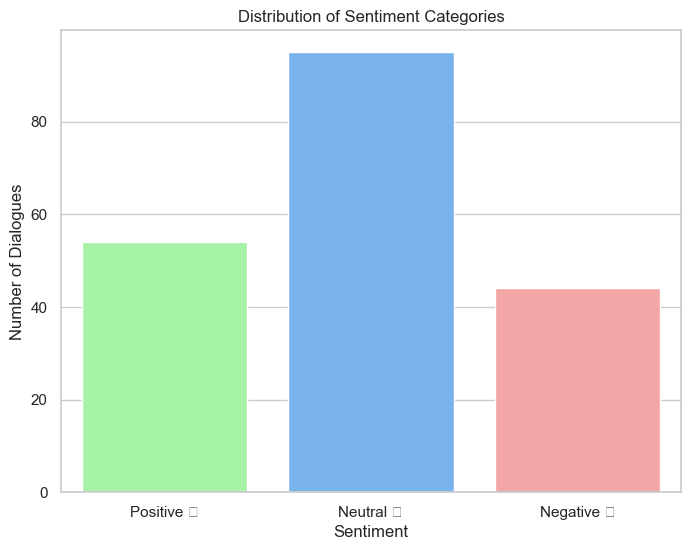

In [24]:
import warnings
warnings.filterwarnings('ignore')


sns.set(style="whitegrid")

# Summary statistics of the Compound Sentiment Scores
print("\nSummary Statistics of Compound Sentiment Scores:")
print(sentiment_dialogues_df['Compound Score'].describe())
x_sentiments = ['Positive 😊', 'Neutral 😐', 'Negative 😡']
x_colors = ['#99ff99', '#66b3ff', '#ff9999']


# Simple bar chart showing the count of each sentiment category
plt.figure(figsize=(8,6))
sns.countplot(x='Sentiment', data=sentiment_dialogues_df, order=x_sentiments, palette=x_colors)
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Number of Dialogues')

filename = 'average_sentiment_distribution.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')

plt.show()
plt.close()


Average Sentiment by Character Role:
          Role  Compound Score
0   Antagonist       -0.192657
1  Protagonist        0.015922
2   Supporting        0.095864


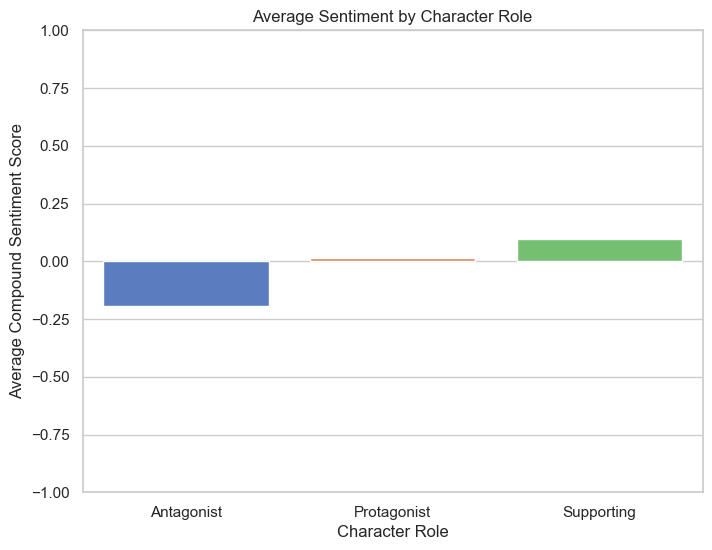

In [25]:
# Calculate average sentiment for each role
role_sentiment = sentiment_dialogues_df.groupby('Role')['Compound Score'].mean().reset_index()

# Display the average sentiment by role
print("\nAverage Sentiment by Character Role:")
print(role_sentiment)

# Bar chart to compare average sentiment across roles
plt.figure(figsize=(8,6))
sns.barplot(x='Role', y='Compound Score', data=role_sentiment, palette='muted')
plt.title('Average Sentiment by Character Role')
plt.xlabel('Character Role')
plt.ylabel('Average Compound Sentiment Score')
plt.ylim(-1, 1)  # VADER scores range from -1 to 1

filename = 'average_sentiment_by_char_role.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')

plt.show()
plt.close()


Average Sentiment by Marginalized Status:
   Marginalized  Compound Score
0         False        0.107548
1          True        0.044437


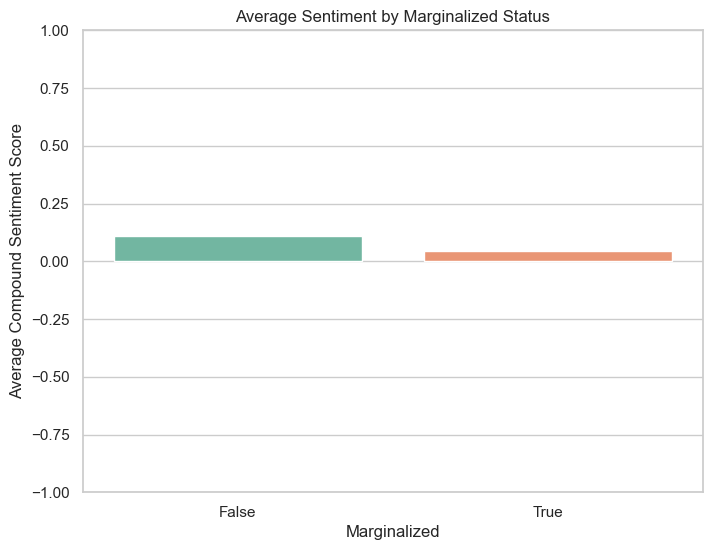

In [26]:
# Calculate average sentiment based on Marginalized status
marginalized_sentiment = sentiment_dialogues_df.groupby('Marginalized')['Compound Score'].mean().reset_index()

# Display the results
print("\nAverage Sentiment by Marginalized Status:")
print(marginalized_sentiment)

# Bar chart to compare average sentiment
plt.figure(figsize=(8,6))
sns.barplot(x='Marginalized', y='Compound Score', data=marginalized_sentiment, palette='Set2')
plt.title('Average Sentiment by Marginalized Status')
plt.xlabel('Marginalized')
plt.ylabel('Average Compound Sentiment Score')
plt.ylim(-1, 1)
filename = 'average_sentiment_by_marginalized_status.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')

plt.show()
plt.close()


Average Sentiment by POC Status:
     POC  Compound Score
0  False        0.107548
1   True        0.044437


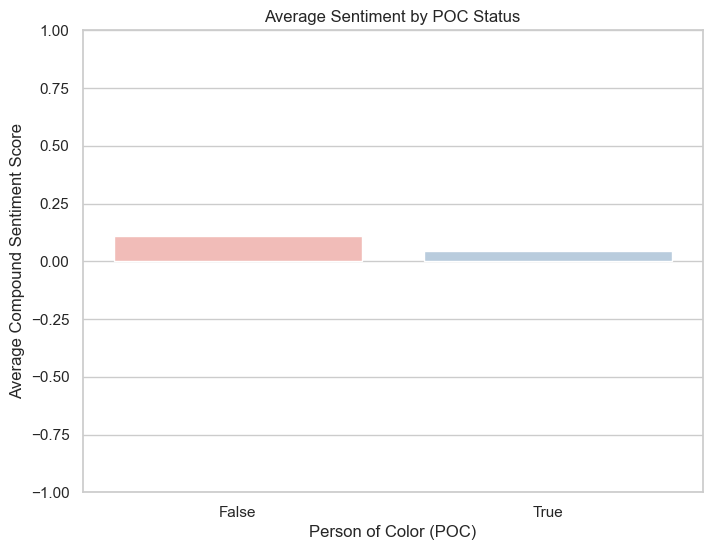

In [27]:
# Calculate average sentiment based on POC status
poc_sentiment = sentiment_dialogues_df.groupby('POC')['Compound Score'].mean().reset_index()

# Display the results
print("\nAverage Sentiment by POC Status:")
print(poc_sentiment)

# Bar chart to compare average sentiment
plt.figure(figsize=(8,6))
sns.barplot(x='POC', y='Compound Score', data=poc_sentiment, palette='Pastel1')
plt.title('Average Sentiment by POC Status')
plt.xlabel('Person of Color (POC)')
plt.ylabel('Average Compound Sentiment Score')
plt.ylim(-1, 1)
filename = 'average_sentiment_by_POC.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')

plt.show()
plt.close()

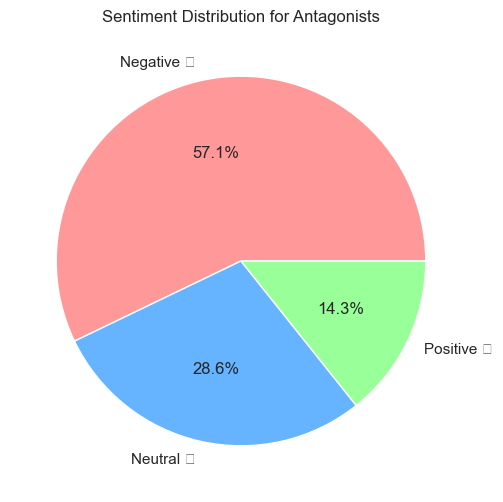

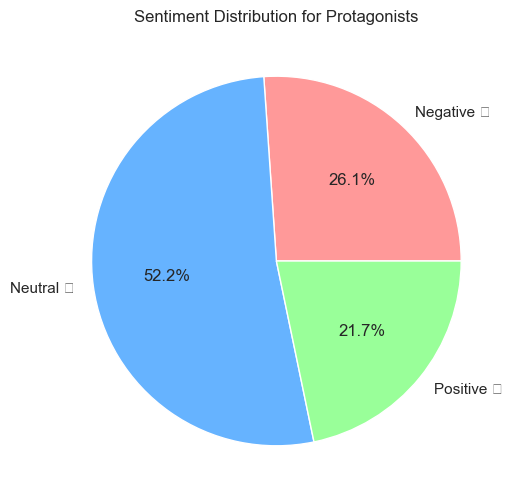

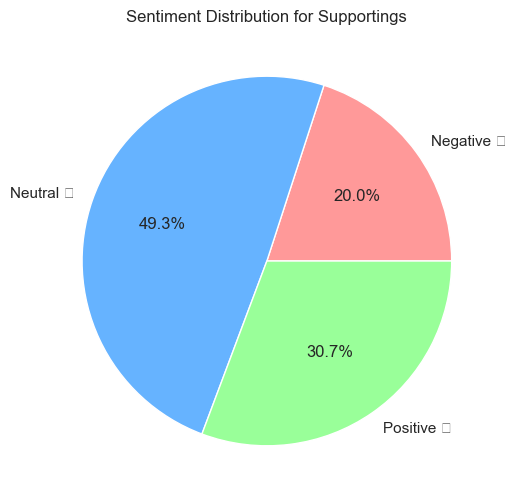

In [28]:
# Calculate sentiment distribution by role
role_sentiment_counts = sentiment_dialogues_df.groupby(['Role', 'Sentiment']).size().reset_index(name='Counts')

# Function to plot pie chart for a given role
def plot_pie(role):
    role_data = role_sentiment_counts[role_sentiment_counts['Role'] == role]
    plt.figure(figsize=(6,6))
    plt.pie(role_data['Counts'], labels=role_data['Sentiment'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
    plt.title(f'Sentiment Distribution for {role}s')
    filename = f'sentiment_distribution_for_{role.lower()}.png'
    filepath = os.path.join(output_viz_path,filename)
    plt.savefig(filepath,dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()
# Plot pie charts for each role
plot_pie('Antagonist')
plot_pie('Protagonist')
plot_pie('Supporting')

In [29]:
# Create a crosstab to count sentiments by Role and Marginalized status
pivot_marginalized = pd.crosstab(
    index=[sentiment_dialogues_df['Role'], sentiment_dialogues_df['Marginalized']],
    columns=sentiment_dialogues_df['Sentiment']
).fillna(0)

# Display the pivot table
print("\nCrosstab of Sentiments by Role and Marginalized Status:")
pivot_marginalized


Crosstab of Sentiments by Role and Marginalized Status:


Sentiment                 Negative 😡  Neutral 😐  Positive 😊
Role        Marginalized                                   
Antagonist  False                  4          2           1
Protagonist True                  12         24          10
Supporting  False                 11         27          22
            True                  17         42          21

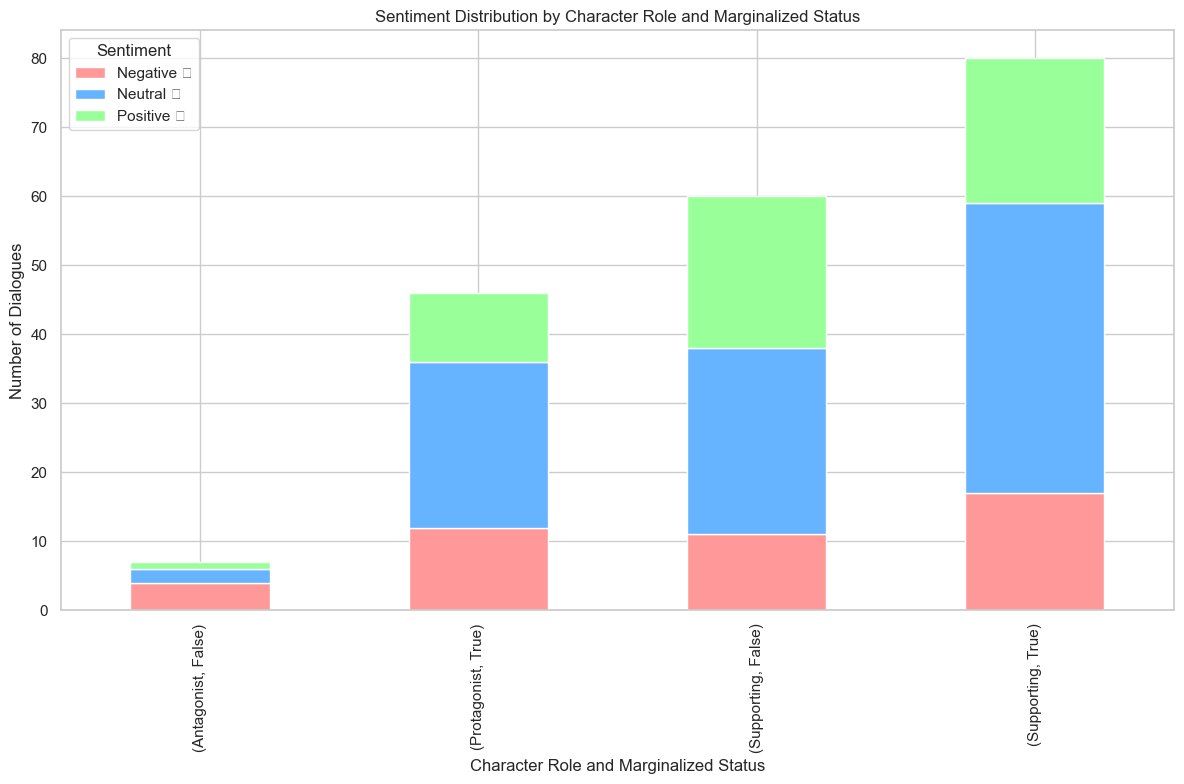

In [30]:
# Reset index to turn MultiIndex into columns
pivot_marginalized_reset = pivot_marginalized.reset_index()

# Rename columns for clarity
pivot_marginalized_reset.columns.name = None
pivot_marginalized_reset = pivot_marginalized_reset.rename(columns={
    'Role': 'Character Role',
    'Marginalized': 'Marginalized Status'
})

# Plotting
pivot_marginalized_reset.set_index(['Character Role', 'Marginalized Status']).plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=['#ff9999','#66b3ff','#99ff99']
)

plt.title('Sentiment Distribution by Character Role and Marginalized Status')
plt.xlabel('Character Role and Marginalized Status')
plt.ylabel('Number of Dialogues')
plt.legend(title='Sentiment')
plt.tight_layout()
filename = 'sentiment_distribution_charrole_and_marg_status.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')
plt.show()


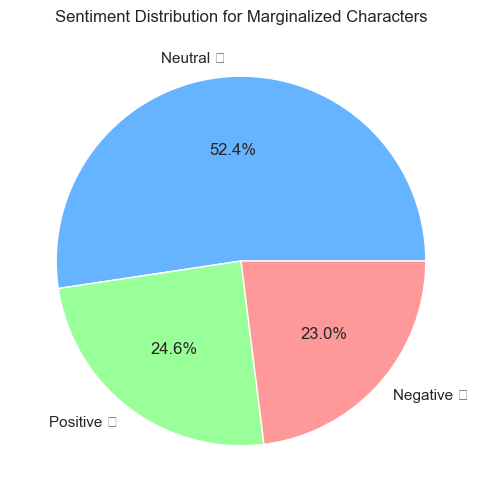

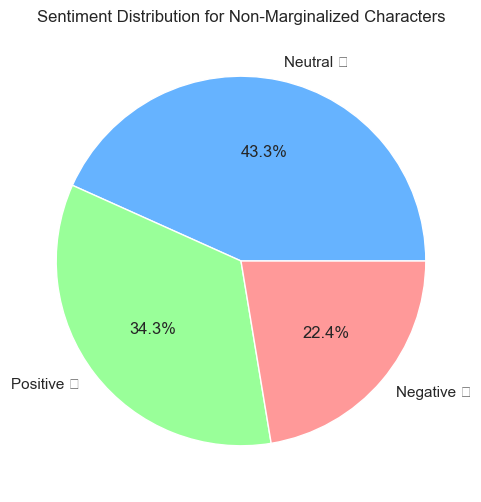

In [31]:
# Define a function to plot pie charts
def plot_pie(data, title, filename,output_path):
    sentiment_counts = data['Sentiment'].value_counts()
    plt.figure(figsize=(6,6))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ff9999'])
    plt.title(title)

    filepath= os.path.join(output_path,filename)
    plt.savefig(filepath,dpi=300,bbox_inches='tight')
    plt.show()
    

# Plot pie chart for Marginalized Characters
marginalized_data = sentiment_dialogues_df[sentiment_dialogues_df['Marginalized'] == True]
plot_pie(marginalized_data, 'Sentiment Distribution for Marginalized Characters','sentiment_distribution_marg_chars.png',output_viz_path)

# Plot pie chart for Non-Marginalized Characters
non_marginalized_data = sentiment_dialogues_df[sentiment_dialogues_df['Marginalized'] == False]
plot_pie(non_marginalized_data, 'Sentiment Distribution for Non-Marginalized Characters','sentiment_distribution_non_marg_chars.png',output_viz_path)

In [32]:
sentiment_dialogues_df.sample(6)

,Film Title,Character,Gender,Race/Ethnicity,Culture,Role,Marginalized,POC,Dialogue,Cleaned Dialogue,Sentiment Scores,Compound Score,Sentiment
129,Mulan,Shang,Male,Chinese,Chinese,Supporting,True,True,Hold the last cannon. Prepare to fight. If...,Hold the last cannon. Prepare to fight. If...,"{'neg': 0.441, 'neu': 0.424, 'pos': 0.136, 'co...",-0.8020,Negative 😡
135,Mulan,Ling,Male,Chinese,Chinese,Supporting,True,True,"Step back guys, give 'em some air.","Step back guys, give them some air.","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
124,Mulan,Shang,Male,Chinese,Chinese,Supporting,True,True,You just gave away our position. Now we're--[...,You just gave away our position. Now we are--...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral 😐
43,Mulan,Mushu,Male,Mythical Creature,Chinese,Supporting,False,False,"Don't even worry about it, I will not lose fac...","Do not even worry about it, I will not lose face.","{'neg': 0.0, 'neu': 0.632, 'pos': 0.368, 'comp...",0.5667,Positive 😊
99,Mulan,Yao,Male,Chinese,Chinese,Supporting,True,True,"Yeah, 'cause I owe you a knuckle sandwich. [g...","Yeah, because I owe you a knuckle sandwich.","{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp...",0.2960,Positive 😊
27,Mulan,Mulan,Female,Chinese,Chinese,Protagonist,True,True,"Please sir, my father has already fought brave...","Please sir, my father has already fought brave...","{'neg': 0.217, 'neu': 0.566, 'pos': 0.217, 'co...",0.0000,Neutral 😐


In [33]:
gender_counts = sentiment_dialogues_df['Gender'].value_counts().reset_index()
gender_counts.columns = ["Gender","Dialogue Count"]
gender_counts.head()

,Gender,Dialogue Count
0,Male,139
1,Female,54


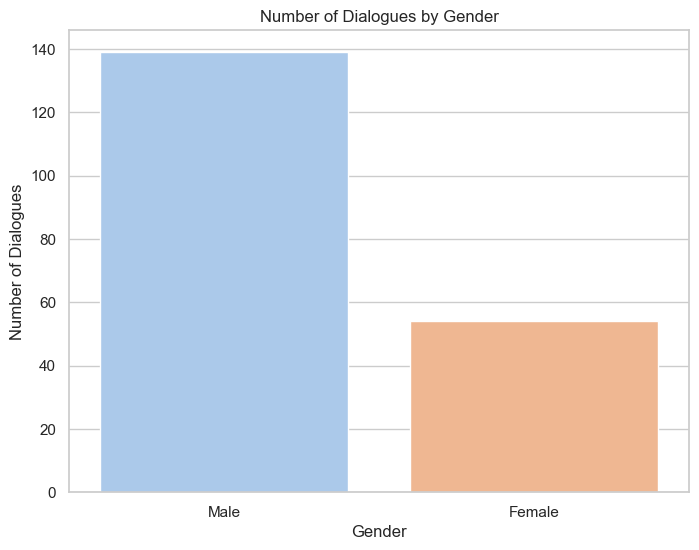

In [34]:
# Plotting Dialogue Counts by Gender
plt.figure(figsize=(8,6))
sns.barplot(x='Gender', y='Dialogue Count', data=gender_counts, palette='pastel')
plt.title('Number of Dialogues by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Dialogues')
filename='dialogue_distribution_by_gender.png'
filepath=os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [35]:
# Calculate sentiment distribution by gender
gender_sentiment_counts = sentiment_dialogues_df.groupby(['Gender', 'Sentiment']).size().reset_index(name='Counts')

gender_sentiment_counts

,Gender,Sentiment,Counts
0,Female,Negative 😡,12
1,Female,Neutral 😐,31
2,Female,Positive 😊,11
3,Male,Negative 😡,32
4,Male,Neutral 😐,64
5,Male,Positive 😊,43


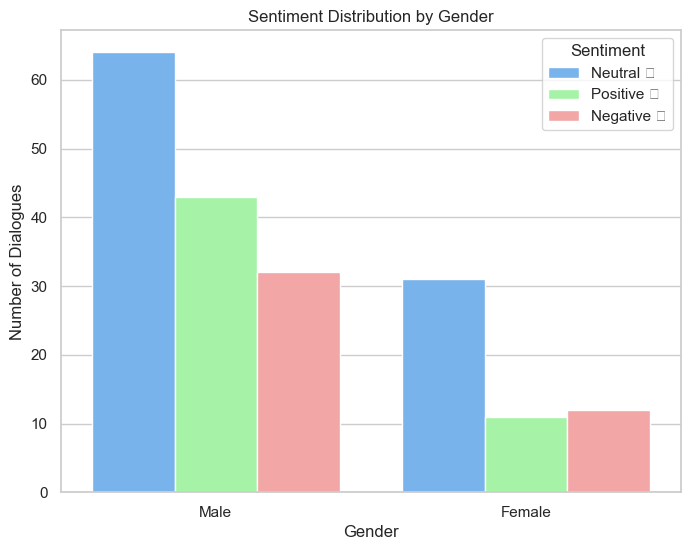

In [47]:
# Plotting Sentiment Distribution by Gender
plt.figure(figsize=(8,6))
sns.countplot(x='Gender', hue='Sentiment', data=sentiment_dialogues_df, palette=['#66b3ff','#99ff99','#ff9999'])
plt.title('Sentiment Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Dialogues')
plt.legend(title='Sentiment')
filename='sentiment_distribution_by_gender.png'
filepath=os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [37]:
# Calculate average sentiment score by gender
gender_avg_sentiment = sentiment_dialogues_df.groupby('Gender')['Compound Score'].mean().reset_index()

gender_avg_sentiment

,Gender,Compound Score
0,Female,0.022059
1,Male,0.083551


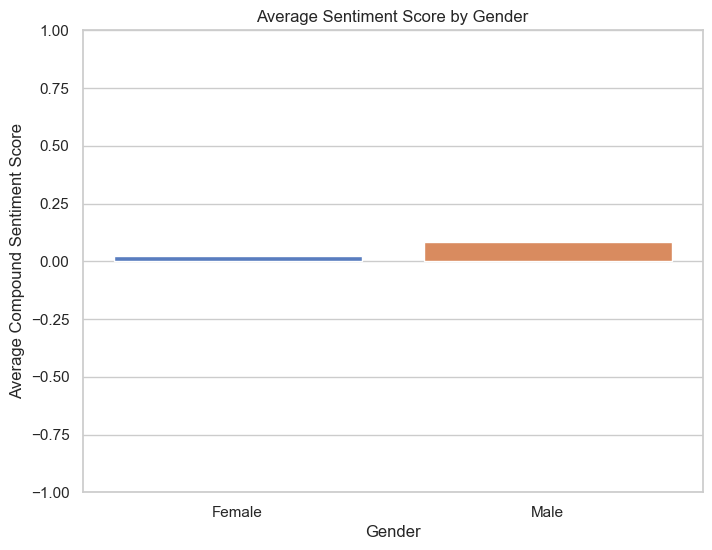

In [38]:
# Plotting Average Sentiment Score by Gender
plt.figure(figsize=(8,6))
sns.barplot(x='Gender', y='Compound Score', data=gender_avg_sentiment, palette='muted')
plt.title('Average Sentiment Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Compound Sentiment Score')
plt.ylim(-1, 1)  # VADER scores range from -1 to 1

filename='average_sentiment_score_by_gender.png'
filepath=os.path.join(output_viz_path,filename)
plt.savefig(filepath,dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [39]:
# Create a new column with descriptive labels for POC status
sentiment_dialogues_df['POC_Status'] = sentiment_dialogues_df['POC'].map({True: 'POC', False: 'Non-POC'})

# Verify the mapping
sentiment_dialogues_df[['Gender', 'POC', 'POC_Status']].sample(6)

,Gender,POC,POC_Status
109,Male,True,POC
25,Female,True,POC
10,Male,True,POC
16,Female,True,POC
63,Male,False,Non-POC
48,Male,False,Non-POC


In [40]:
# Recalculate sentiment distribution using POC_Status
gender_poc_sentiment = sentiment_dialogues_df.groupby(['Gender', 'POC_Status', 'Sentiment']).size().reset_index(name='Counts')

# Display the updated grouped data
gender_poc_sentiment

,Gender,POC_Status,Sentiment,Counts
0,Female,POC,Negative 😡,12
1,Female,POC,Neutral 😐,31
2,Female,POC,Positive 😊,11
3,Male,Non-POC,Negative 😡,15
4,Male,Non-POC,Neutral 😐,29
5,Male,Non-POC,Positive 😊,23
6,Male,POC,Negative 😡,17
7,Male,POC,Neutral 😐,35
8,Male,POC,Positive 😊,20


In [41]:
# Pivot the data for stacked bar plot
pivot_gender_poc = gender_poc_sentiment.pivot_table(
    index=['Gender', 'POC_Status'],
    columns='Sentiment',
    values='Counts',
    fill_value=0
).reset_index()

pivot_gender_poc

Sentiment,Gender,POC_Status,Negative 😡,Neutral 😐,Positive 😊
0,Female,POC,12.0,31.0,11.0
1,Male,Non-POC,15.0,29.0,23.0
2,Male,POC,17.0,35.0,20.0


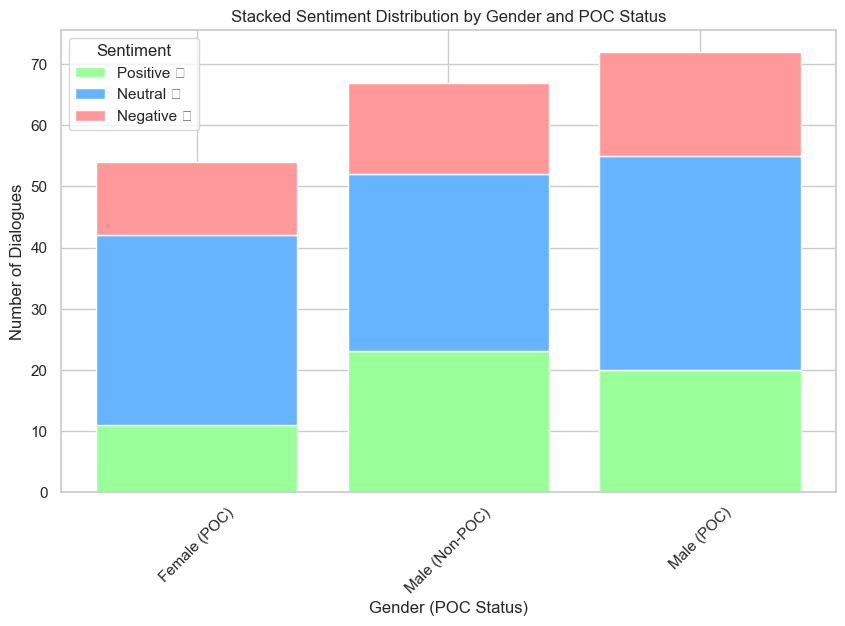

In [42]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Initialize the bottom position for stacking
bottom = None

# Define the sentiments and corresponding colors
sentiments = ['Positive 😊', 'Neutral 😐', 'Negative 😡']
colors = ['#99ff99', '#66b3ff', '#ff9999']

# Loop through sentiments to create stacked bars
for i, sentiment in enumerate(sentiments):
    if i == 0:
        plt.bar(
            pivot_gender_poc['Gender'] + ' (' + pivot_gender_poc['POC_Status'] + ')',
            pivot_gender_poc[sentiment],
            color=colors[i],
            label=sentiment
        )
        bottom = pivot_gender_poc[sentiment]
    else:
        plt.bar(
            pivot_gender_poc['Gender'] + ' (' + pivot_gender_poc['POC_Status'] + ')',
            pivot_gender_poc[sentiment],
            bottom=bottom,
            color=colors[i],
            label=sentiment
        )
        bottom += pivot_gender_poc[sentiment]

# Add title and labels
plt.title('Stacked Sentiment Distribution by Gender and POC Status')
plt.xlabel('Gender (POC Status)')
plt.ylabel('Number of Dialogues')
plt.legend(title='Sentiment')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Save the plot
#plt.savefig(os.path.join(output_folder, 'stacked_bar_charts', 'stacked_sentiment_distribution_by_gender_poc.png'), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Close the plot to free memory
plt.close()

In [43]:
# Create a combined category for POC and Marginalized Status
sentiment_dialogues_df['POC_Marginalized'] = sentiment_dialogues_df.apply(
    lambda row: 'POC & Marginalized' if row['POC_Status'] == 'POC' and row['Marginalized'] else
                'POC & Non-Marginalized' if row['POC_Status'] == 'POC' and not row['Marginalized'] else
                'Non-POC & Marginalized' if row['POC_Status'] == 'Non-POC' and row['Marginalized'] else
                'Non-POC & Non-Marginalized',
    axis=1
)

# Display the updated DataFrame
sentiment_dialogues_df[['Gender', 'POC_Marginalized', 'Sentiment']].head()

,Gender,POC_Marginalized,Sentiment
0,Male,POC & Marginalized,Neutral 😐
1,Male,POC & Marginalized,Positive 😊
2,Male,POC & Marginalized,Neutral 😐
3,Male,POC & Marginalized,Negative 😡
4,Male,POC & Marginalized,Negative 😡


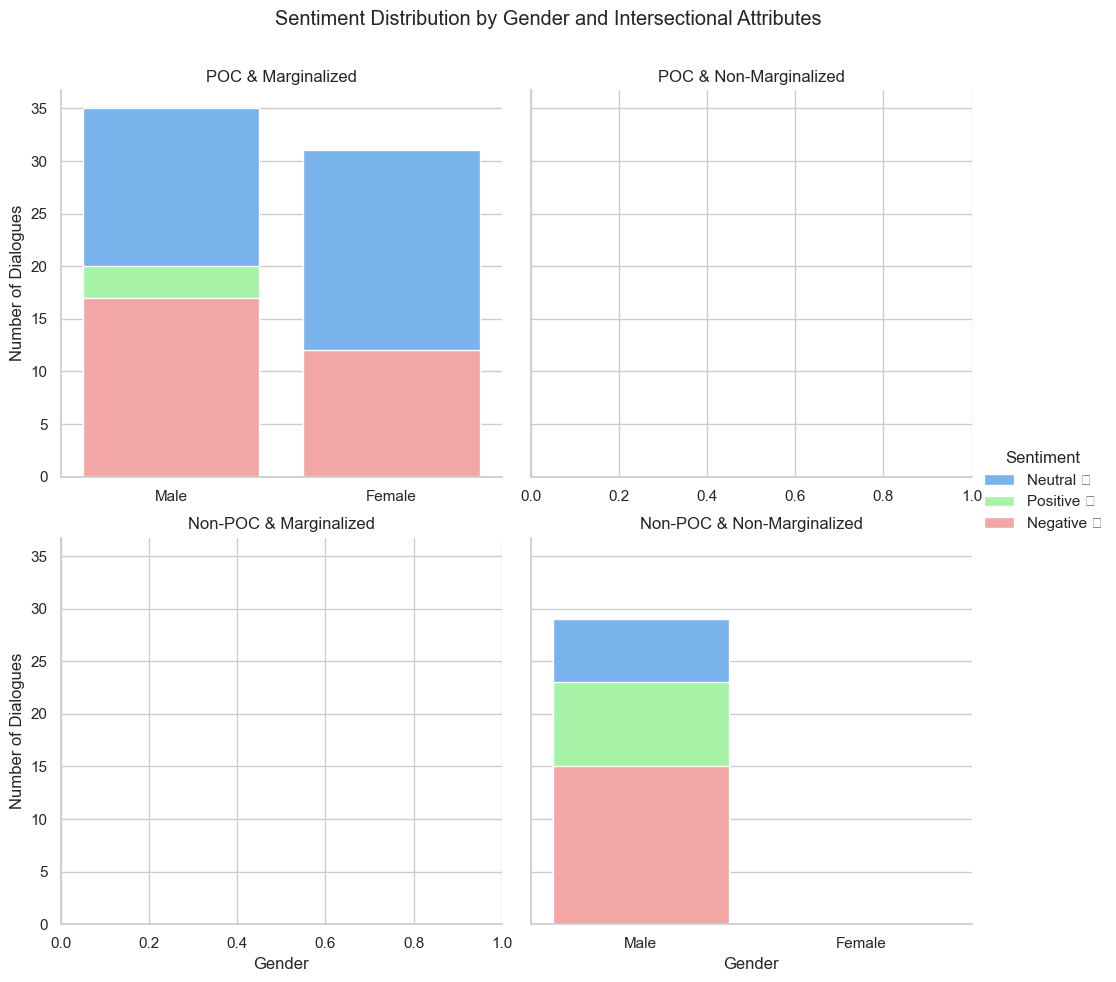

In [44]:
# Define all possible categories for POC_Marginalized
categories = [
    'POC & Marginalized',
    'POC & Non-Marginalized',
    'Non-POC & Marginalized',
    'Non-POC & Non-Marginalized'
]

# Update the 'POC_Marginalized' column with categorical type
sentiment_dialogues_df['POC_Marginalized'] = pd.Categorical(
    sentiment_dialogues_df['POC_Marginalized'],
    categories=categories
)

# Recreate the FacetGrid with the defined categories
g = sns.FacetGrid(
    sentiment_dialogues_df,
    col='POC_Marginalized',
    hue='Sentiment',
    col_wrap=2,
    height=5,
    palette=['#66b3ff','#99ff99','#ff9999'],
    sharex=False
)

g.map(sns.countplot, 'Gender', order=['Male', 'Female'])

# Add legend and titles
g.add_legend(title='Sentiment')
g.set_axis_labels('Gender', 'Number of Dialogues')
g.set_titles("{col_name}")

# Adjust the layout and add a main title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Sentiment Distribution by Gender and Intersectional Attributes')

# Save the FacetGrid plot
#g.savefig(os.path.join(output_folder, 'bar_charts', 'sentiment_distribution_facetgrid_complete.png'), dpi=300, bbox_inches='tight')
filename = 'sentiment_distribution_facetgrid_complete.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath, dpi=300,bbox_inches='tight')

# Display the plot
plt.show()

# Close the plot to free memory
plt.close()

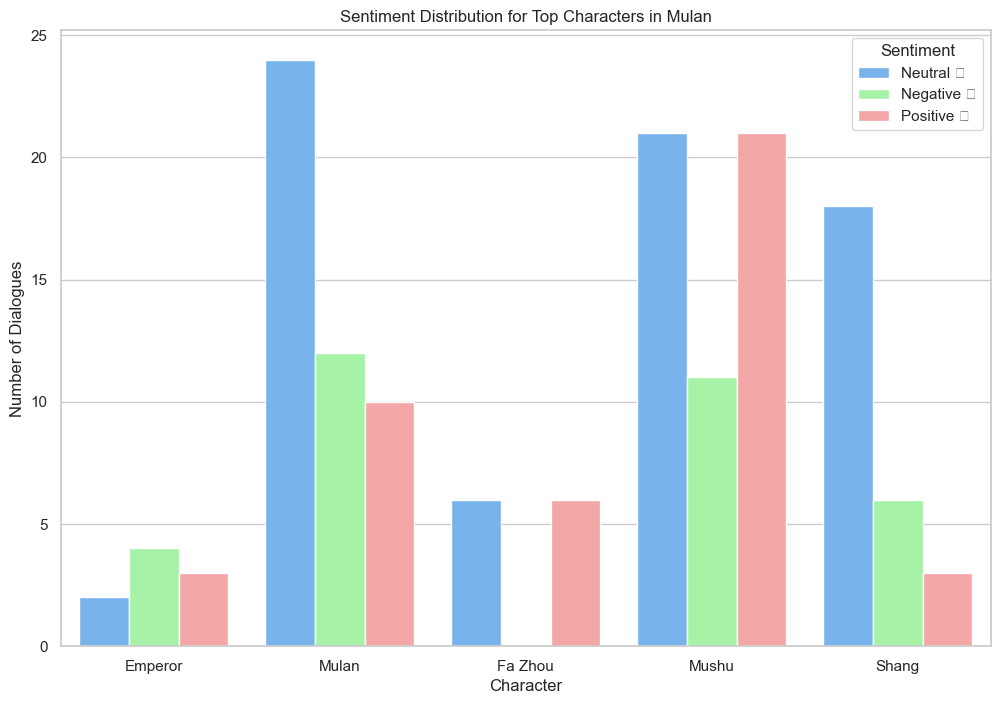

In [45]:
# Identify top 5 characters by dialogue count
top_characters = sentiment_dialogues_df['Character'].value_counts().head(5).index.tolist()

# Filter data for top characters
top_characters_data = sentiment_dialogues_df[sentiment_dialogues_df['Character'].isin(top_characters)]

# Plot sentiment distribution for top characters
plt.figure(figsize=(12, 8))
sns.countplot(x='Character', hue='Sentiment', data=top_characters_data, palette=['#66b3ff','#99ff99','#ff9999'])
plt.title('Sentiment Distribution for Top Characters in Mulan')
plt.xlabel('Character')
plt.ylabel('Number of Dialogues')
plt.legend(title='Sentiment')
filename = 'sentiment_distribution_top_characters.png'
filepath = os.path.join(output_viz_path,filename)
plt.savefig(filepath, dpi=300,bbox_inches='tight')
plt.show()
plt.close()